# View Alternative Decision Thresholds (for AutoMLPipe-BC)
Allows users to interactively examine different decision thresholds (rather than the standard .5 probability of case) for a target model and see how new thresholds impact model performance metrics.

This notebook is designed to be run on a single model (i.e. specific dataset, CV, and algorithm).

Designed to operate following application of pipeline phases 1-6. Relies on folder/file hierarchy saved by the pipeline.
 

## Import Packages

In [1]:
%matplotlib notebook
from ipywidgets import *

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
pd.options.display.float_format = "{:.4f}".format
sns.set(palette='rainbow', context='talk')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.widgets import Slider

import pickle
import seaborn as sns
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## Set Run Parameters

In [2]:
experiment_path = "C:/Users/ryanu/Documents/Analysis/AutoMLPipe_Experiments/hcc_demo"
targetDataName = 'hcc-data_example' # specify a specific dataset
algorithm = 'Decision Tree' # specify algorithm
cvCount = 0 #specify the CV number

#available_algorithms = ['Naive Bayes','Logistic Regression','Decision Tree','Random Forest','Gradient Boosting','XGB','LGB','SVM','ANN','K Neighbors','eLCS','XCS','ExSTraCS']

## Automatically detect data folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)
experiment_name = experiment_path.split('/')[-1] #Name of experiment folder
datasets.remove('metadata.csv')
datasets.remove('metadata.pickle')
datasets.remove('algInfo.pickle')
try:
    datasets.remove('jobsCompleted')
except:
    pass
try:
    datasets.remove('UsefulNotebooks')
except:
    pass
try:
    datasets.remove('logs')
    datasets.remove('jobs')
except:
    pass
try:
    datasets.remove('DatasetComparisons') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove('KeyFileCopy') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove(experiment_name+'_ML_Pipeline_Report.pdf') #If it has been run previously (overwrite)
except:
    pass
datasets = sorted(datasets) #ensures consistent ordering of datasets
print("Analyzed Datasets: "+str(datasets))

Analyzed Datasets: ['hcc-data_example', 'hcc-data_example_no_covariates']


## Load other necessary parameters

In [4]:
jupyterRun = 'True'
#Unpickle metadata from previous phase
file = open(experiment_path+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
#Load variables specified earlier in the pipeline from metadata
class_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = int(metadata['CV Partitions'])
primary_metirc = metadata['Primary Metric']

#Unpickle algorithm information from previous phase
file = open(experiment_path+'/'+"algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()
algorithms = []
abbrev = {}
colors = {}
for key in algInfo:
    if algInfo[key][0]: # If that algorithm was used
        algorithms.append(key)
        abbrev[key] = (algInfo[key][1])
        colors[key] = (algInfo[key][2])
        
print(algorithms)

['Naive Bayes', 'Logistic Regression', 'Decision Tree']


## Define necessary methods

In [5]:
def lnsp(initial, max, num):
    diff = max - initial
    list1 = []
    for i in range(num):
        list1.append(initial + (i * diff/num))
    return list1


def get_fp_tp(y_test, proba, thresh):
    pred = []
    fp = 0
    tp = 0
    fn = 0
    tn = 0
    threshold = round(thresh, 2)
    for i in range(len(proba)):
        if proba[i] >= threshold:
            pred.append(1)
        elif proba[i] < threshold:
            pred.append(0)
    np.asarray(y_test)
    y_test = y_test.tolist()
    for i in range(len(y_test)):
        if y_test[i] == pred[i]:
            if y_test[i] == 1:
                tp += 1
            elif y_test[i] == 0:
                tn += 1
        elif y_test[i] != pred[i]:
            if pred[i]== 1:
                fp += 1
            elif pred[i] == 0:
                fn += 1
    return fp, tp, fn, tn

def get_fpr_tpr(y_test, proba):
    negatives = np.sum(y_test == 0)
    positives = np.sum(y_test == 1)
    columns = ['threshold', 'false_positive_rate', 'true_positive_rate']
    fptp = pd.DataFrame(columns=columns, dtype=np.number)
    thresholds = np.linspace(0, 1, 101)
    for i, threshold in enumerate(thresholds):
        fptp.loc[i, 'threshold'] = threshold
        false_positives, true_positives, fn, tn = get_fp_tp(y_test, proba, threshold)
        fptp.loc[i, 'false_positive_rate'] = false_positives / negatives
        fptp.loc[i, 'true_positive_rate'] = true_positives / positives
    fptp.head(15)
    return fptp

def get_tfpn(y_test, proba):
    columns = ['threshold', 'false_positives', 'true_positives', 'false_negatives',]
    tfpn = pd.DataFrame(columns=columns, dtype=np.number)
    thresholds = np.linspace(0, 1, 101)
    for i, threshold in enumerate(thresholds):
        tfpn.loc[i, 'threshold'] = round(threshold, 2)
        false_positives, true_positives, false_negatives, true_negatives = get_fp_tp(y_test, proba, round(threshold, 2))
        tfpn.loc[i, 'false_positives'] = false_positives
        tfpn.loc[i, 'true_positives'] = true_positives
        tfpn.loc[i, 'false_negatives'] = false_negatives
        tfpn.loc[i, 'true_negatives'] = true_negatives
    return tfpn

def cm_maker(y_test, proba, thresh):
    tfpn = get_tfpn(y_test, proba)
    tfpn_partial = tfpn.loc[tfpn['threshold'] == thresh]
    #print(np.array(tfpn_partial.true_positives))
    cm_part_1 = np.array(tfpn_partial.true_positives)
    cm_part_2 = np.array(tfpn_partial.false_negatives)
    cm_part_3 = np.array(tfpn_partial.false_positives)
    cm_part_4 = np.array(tfpn_partial.true_negatives)
    merge = np.concatenate((cm_part_1, cm_part_2))
    merge_2 = np.concatenate((cm_part_3, cm_part_4))
    cm_final = np.concatenate(([merge], [merge_2]))
    return cm_final

def graph_roc(y_test, proba, fig, ax, threshold, tpr, fpr, AUC):
    # ax = ax.flatten()
    auc=metrics.roc_auc_score(y_test, proba)
    # ax.plot(fpr, tpr, label="AUC=" + str(auc))
    ax.plot(fpr, tpr, label='AUC:' + str(AUC))
    ax.set(ylabel = ('True Positive Rate'),
    xlabel = ('False Positive Rate'))
    ax.legend()

def getdata(threshold, fprtpr):
    point = fprtpr.loc[fprtpr['threshold'] == threshold]
    fpr = np.array(point.false_positive_rate)
    tpr = np.array(point.true_positive_rate)
    return fpr, tpr

def graph_line(ax, threshold, fprtpr):
    fpr, tpr = getdata(threshold, fprtpr)
    vert_line = ax.axvline(x=fpr, color='gray', linestyle='--')
    hori_line = ax.axhline(y=tpr, color='gray', linestyle='--')

        # vert_line.remove(vert_line)
        # vert_line = ax.axvline(x=(threshold*0.2), color='gray', linestyle='--')
    return vert_line, hori_line

def plot_point(ax, threshold, fprtpr):
    fpr, tpr = getdata(threshold, fprtpr)
    ptplt = ax.plot(fpr, tpr, color='blue', marker='o', markersize=8)
    ax.legend()
    return ptplt

def get_cms(y_test, proba):
    thresholds = np.linspace(0, 1, 101)
    ls = []
    for i in thresholds:
        cm = cm_maker(y_test, proba, round(i, 2)).tolist()
        ls.append(cm)
    return ls

def get_auc(model, x_test, y_test):
    y_predict = model.predict(x_test)
    AUC = metrics.roc_auc_score(y_test, y_predict)
    print(AUC)


## Generate ROC and PRC plots

<IPython.core.display.Javascript object>


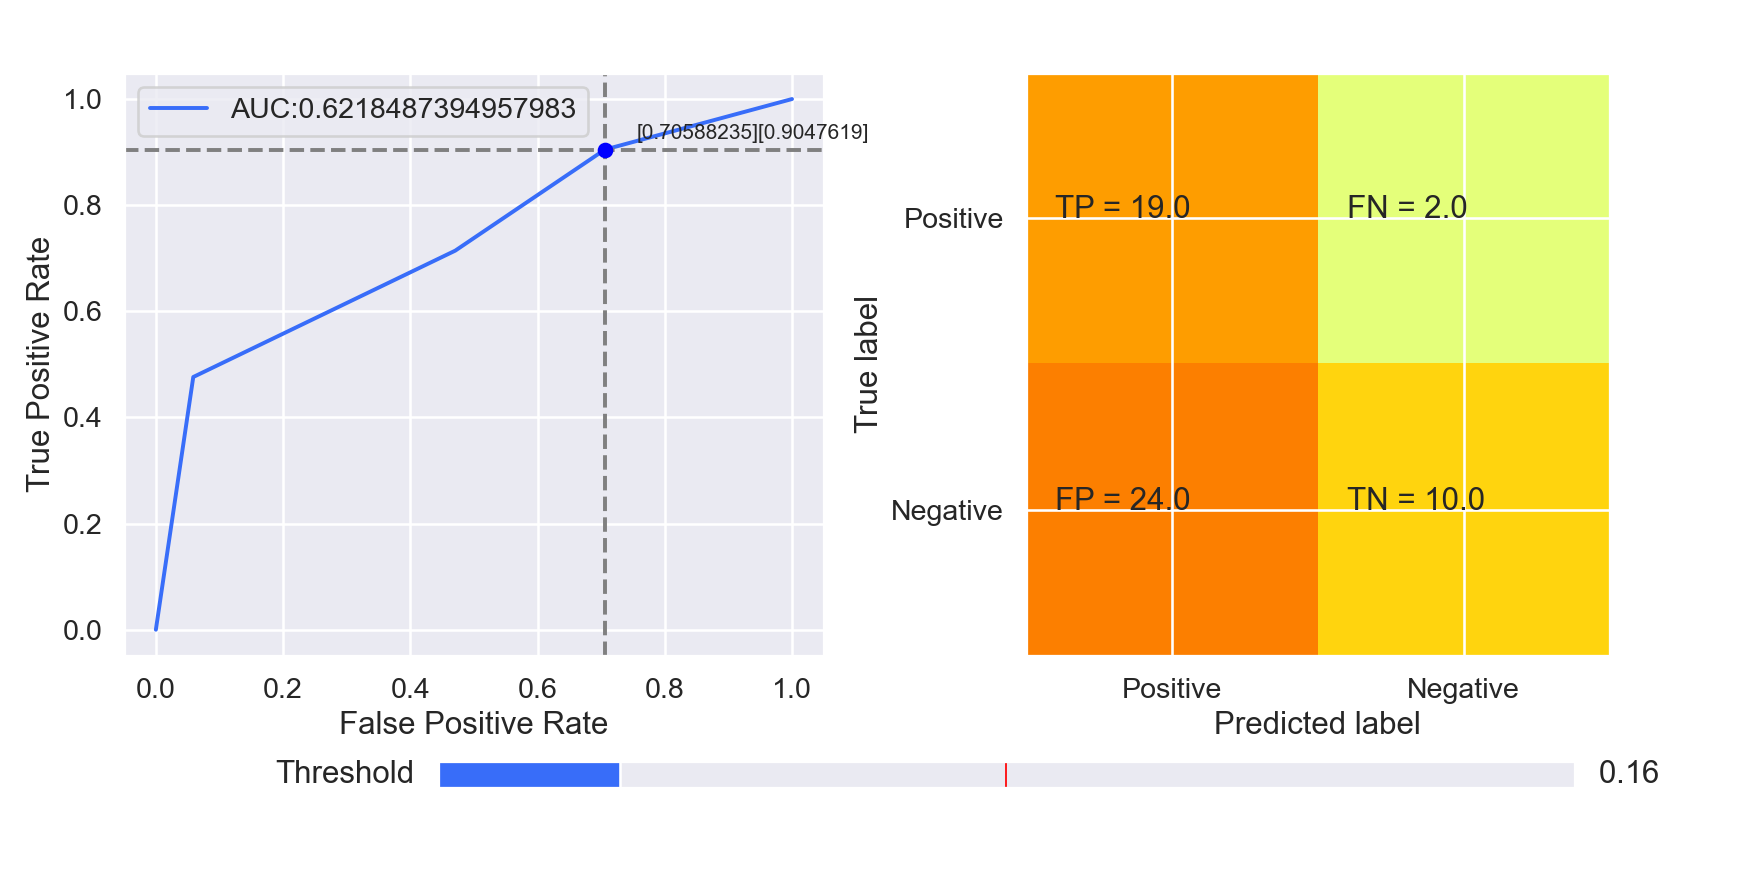

In [6]:
global point, hline, vline, coordinate

full_path = experiment_path+'/'+targetDataName

#Load pickled metric file for given algorithm and cv
model_file = full_path+'/models/pickledModels/'+abbrev[algorithm]+"_"+str(cvCount)+'.pickle'
file = open(model_file, 'rb')
model = pickle.load(file)
file.close()
            
#load testing data
test_file_path = full_path + '/CVDatasets/' + targetDataName + "_CV_" + str(cvCount) + "_Test.csv"
test = pd.read_csv(test_file_path)
if instance_label != 'None':
    test = test.drop(instance_label,axis=1)
x_test = test.drop(class_label,axis=1).values
y_test = test[class_label].values
del test #memory cleanup

proba = model.predict_proba(x_test)[:,1]
tfpn = get_tfpn(y_test, proba)
tfpn.to_csv('tfpn.csv')
# plt.figure(figsize=(9, 9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score)
# plt.title(all_sample_title, size=15);
# plt.show()
threshold = 0.5
fprtpr = get_fpr_tpr(y_test, proba)
fprtpr.threshold = round(fprtpr.threshold, 2)
fpr_roc = fprtpr.false_positive_rate
tpr_roc = fprtpr.true_positive_rate
fprtpr.to_csv('fprtpr.csv')
#cm = cm_maker(y_test, proba, threshold)

y_predict = model.predict(x_test)
AUC = metrics.roc_auc_score(y_test, y_predict)


cms = get_cms(y_test, proba)
cm = np.asarray(cms[int(round(threshold, 0) * 100)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14, 7))
fig.tight_layout(pad = 2)
fpr, tpr = getdata(threshold, fprtpr)
coordinate = ax[0].text(fpr+0.05, tpr+0.02, s=str(fpr) + str(tpr), fontsize= 12)
graph_roc(y_test, proba, fig, ax[0], threshold, tpr_roc, fpr_roc, AUC)
ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
fig.subplots_adjust(bottom=0.25)
classNames = ['Positive', 'Negative']
tick_marks = np.arange(len(classNames))
ax[1].set(ylabel = 'True label',
        xlabel = 'Predicted label',
        xticks = np.arange(len(classNames)),
        yticks = np.arange(len(classNames)),
       xticklabels = classNames,
       yticklabels = classNames)
s = [['TP', 'FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        ax[1].text(j-0.3, i, str(s[i][j]) + " = " + str(cm[i][j]))
fig.subplots_adjust(bottom=0.25)

vline, hline = graph_line(ax[0], threshold, fprtpr)
point, = plot_point(ax[0], threshold, fprtpr)

sli_ax = plt.axes([0.25, 0.1, .65, .03])
thr_slider = Slider(sli_ax, 'Threshold', valmin=0, valmax=1, valinit=0.5, valstep=0.01)


def update(val):
    global point, coordinate
    ax[1].clear()
    threshold = round(thr_slider.val, 2)

    coordinate.remove()
    fpr, tpr = getdata(threshold, fprtpr)
    hline.set_ydata(y=tpr)
    vline.set_xdata(x=fpr)
    point.set_data(fpr, tpr)
    point.set_data(fpr, tpr)
    y_predict = model.predict(x_test)
    AUC = metrics.roc_auc_score(y_test, y_predict)
    coordinate = ax[0].text(fpr+0.05, tpr+0.02, s=str(fpr)+str(tpr), fontsize = 12)

    cm = np.asarray(cms[int(round(threshold*100, 0))])
    ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Positive', 'Negative']
    # img.('Confusion Matrix - Test Data')
    tick_marks = np.arange(len(classNames))
    ax[1].set(ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(len(classNames)),
           yticks=np.arange(len(classNames)),
           xticklabels=classNames,
           yticklabels=classNames)
    s = [['TP', 'FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            ax[1].text(j-.4, i, str(s[i][j]) + " = " + str(cm[i][j]))

    fig.canvas.draw()

thr_slider.on_changed(update)
plt.show()